# Instalacion y carga de utilidades

In [2]:
#Instalacion de librerias
!pip install yfinance pyts statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 19.8 MB/s eta 0:00:00


In [3]:
#Carga de libraries
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from scipy.stats import skew, kurtosis, probplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.forecasting.stl import STLForecast


In [4]:
class timeSeriesAnalizer:
    def __init__(self, ticker, start, end):
        print("###################################################################")
        print(f"Creando objeto para la serie de {ticker}")
        self.ticker = ticker
        self.start = start
        self.end = end
        #Extrayendo datos desde yahoo finance
        self.data = yf.download(tickers=ticker, start=start, end=end)
        #Tomando el precio de cierre ajustado
        self.data_adjclose = self.data[["Adj Close"]]
        self.data['Close_Diff'] = self.data['Adj Close'].diff()
        self.data.dropna(inplace=True)

        #Calculando estadisticos
        self.mean = self.data_adjclose.mean()
        self.variance = self.data_adjclose.var()
        self.skewness = skew(self.data_adjclose)
        self.kurt = kurtosis(self.data_adjclose)

    def show_basic_statistics(self, difference=False):
        #Showing descriptive statistics
        print("############################################")
        print("Showing descriptive statistics!:")
        print(self.data.describe())
        if(difference==False):
            print("############################################")
            print("Showing Moment based statistics!:")
            print(f'Mean: {self.mean[0]}')
            print(f'Variance: {self.variance[0]}')
            print(f'Skewness: {self.skewness[0]}')
            print(f'Kurtosis: {self.kurt[0]}')
        else:
            print("############################################")
            print("Showing Moment based statistics!:")
            print(f'Mean: {self.data[["Close_Diff"]].mean()[0]}')
            print(f'Variance: {self.data[["Close_Diff"]].var()[0]}')
            print(f'Skewness: {skew(self.data[["Close_Diff"]])[0]}')
            print(f'Kurtosis: {kurtosis(self.data[["Close_Diff"]])[0]}')


    def show_distribution(self, difference=False):
        print("###################################################################")
        if(difference):
          print(f"Showing distribution of First Difference of {self.ticker}")
          fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
          self.data[['Close_Diff']].plot(ax=ax1)
          ax1.set_title("First Difference Adj Price of "+ self.ticker)
          self.data[['Close_Diff']].hist(bins=10, ax=ax2)
          ax2.set_title("Histogram of First Difference Adj Price of "+ self.ticker)
          probplot(self.data['Close_Diff'], dist="norm", plot=plt)
          ax3.set_title('QQ-Plot');
        else:
          print(f"Showing distribution of {self.ticker}")
          fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
          self.data_adjclose.plot(ax=ax1)
          ax1.set_title("Adj Price of "+ self.ticker)
          self.data_adjclose.hist(bins=10, ax=ax2)
          ax2.set_title("Histogram of Adj Price of "+ self.ticker)
          probplot(self.data_adjclose["Adj Close"], dist="norm", plot=plt)
          ax3.set_title('QQ-Plot');

    def show_acf_pacf(self, difference=False):
        if difference:
          print("###################################################################")
          print(f"Showing ACF and PACF of First Difference for {self.ticker}")
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
          plot_acf(self.data[['Close_Diff']], lags=20, ax=ax1)
          ax1.set_title('Autocorrelation Function of First Difference of '+ self.ticker)
          plot_pacf(self.data[['Close_Diff']], lags=20, ax=ax2)
          ax2.set_title('Partial Autocorrelation Function of First Difference of '+ self.ticker);
        else:
          print(f"Showing ACF and PACF of {self.ticker}")
          fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
          plot_acf(self.data_adjclose, lags=20, ax=ax1)
          ax1.set_title('Autocorrelation Function of '+ self.ticker)
          plot_pacf(self.data_adjclose, lags=20, ax=ax2)
          ax2.set_title('Partial Autocorrelation Function '+ self.ticker);

    def apply_adf_test(self, difference=False):
        print("###################################################################")
        if difference:
          print(f"Applying ADF Test to First Difference of {self.ticker}")
          series = self.data[["Close_Diff"]]
        else:
          print(f"Applying ADF Test to {self.ticker}")
          series = self.data_adjclose

        # ADF Test
        result = adfuller(series, autolag='AIC')
        print(f'ADF Statistic: {result[0]}')
        print(f'n_lags: {result[1]}')
        print(f'p-value: {result[1]}')
        for key, value in result[4].items():
          print('Critial Values:')
          print(f'   {key}, {value}')
        if(result[1] < 0.05):
          print("We Reject null hypothesis of non stationarity")
        else:
          print("We Fail to reject null hypothesis of non stationarity")


    def apply_STL_decompose(self, difference=False):
        print("###################################################################")
        print(f"Applying STL Decomposition to {self.ticker}")
        # Descomposición de la serie temporal
        if difference:
          series = self.data[["Close_Diff"]]
        else:
          series = self.data_adjclose
        decomposition = seasonal_decompose(series, model='additive', period=252)  # Usando datos diarios, period es aprox. un año
        fig = decomposition.plot()
        fig.axes[0].set_ylabel('Observado')
        fig.axes[1].set_ylabel('Tendencia')
        fig.axes[2].set_ylabel('Estacionalidad')
        fig.axes[3].set_ylabel('Residuo')
        fig.axes[0].set_xlabel('Fecha')
        fig.axes[1].set_xlabel('Fecha')
        fig.axes[2].set_xlabel('Fecha')
        fig.axes[3].set_xlabel('Fecha')
        plt.show()



# Extracción de datos

In [5]:
Analizer = timeSeriesAnalizer("NVDA", "2018-01-01", "2024-06-30")

###################################################################
Creando objeto para la serie de NVDA


[*********************100%%**********************]  1 of 1 completed


# Análisis de datos Exploratorio

In [6]:
Analizer.data.head()

,Open,High,Low,Close,Adj Close,Volume,Close_Diff
Date,,,,,,,
2018-01-03,5.10250,5.34250,5.09375,5.31175,5.255147,914704000,0.324503
2018-01-04,5.39400,5.45125,5.31725,5.33975,5.282848,583268000,0.027701
2018-01-05,5.35475,5.42275,5.27700,5.38500,5.327617,580124000,0.044768
2018-01-08,5.51000,5.62500,5.46450,5.55000,5.490858,881216000,0.163241
2018-01-09,5.55550,5.59550,5.46600,5.54850,5.489374,497000000,-0.001484


In [7]:
Analizer.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1632 entries, 2018-01-03 to 2024-06-28
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1632 non-null   float64
 1   High        1632 non-null   float64
 2   Low         1632 non-null   float64
 3   Close       1632 non-null   float64
 4   Adj Close   1632 non-null   float64
 5   Volume      1632 non-null   int64  
 6   Close_Diff  1632 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 102.0 KB


In [8]:
Analizer.show_basic_statistics()

############################################
Showing descriptive statistics!:
              Open         High          Low        Close    Adj Close  \
count  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000   
mean     21.168251    21.558096    20.758406    21.181967    21.153856   
std      23.006150    23.423105    22.532456    23.012159    23.020466   
min       3.162250     3.249500     3.111500     3.177000     3.151916   
25%       6.117625     6.212062     6.021875     6.130313     6.077234   
50%      13.628625    13.839875    13.361750    13.598875    13.566543   
75%      24.362249    25.008750    23.807500    24.418000    24.383590   
max     139.800003   140.759995   130.690002   135.580002   135.580002   

             Volume   Close_Diff  
count  1.632000e+03  1632.000000  
mean   4.775204e+08     0.072677  
std    2.106495e+08     0.998051  
min    9.788400e+07    -8.470299  
25%    3.417230e+08    -0.177463  
50%    4.406720e+08     0.024333  
75%    5.8

###################################################################
Showing distribution of NVDA


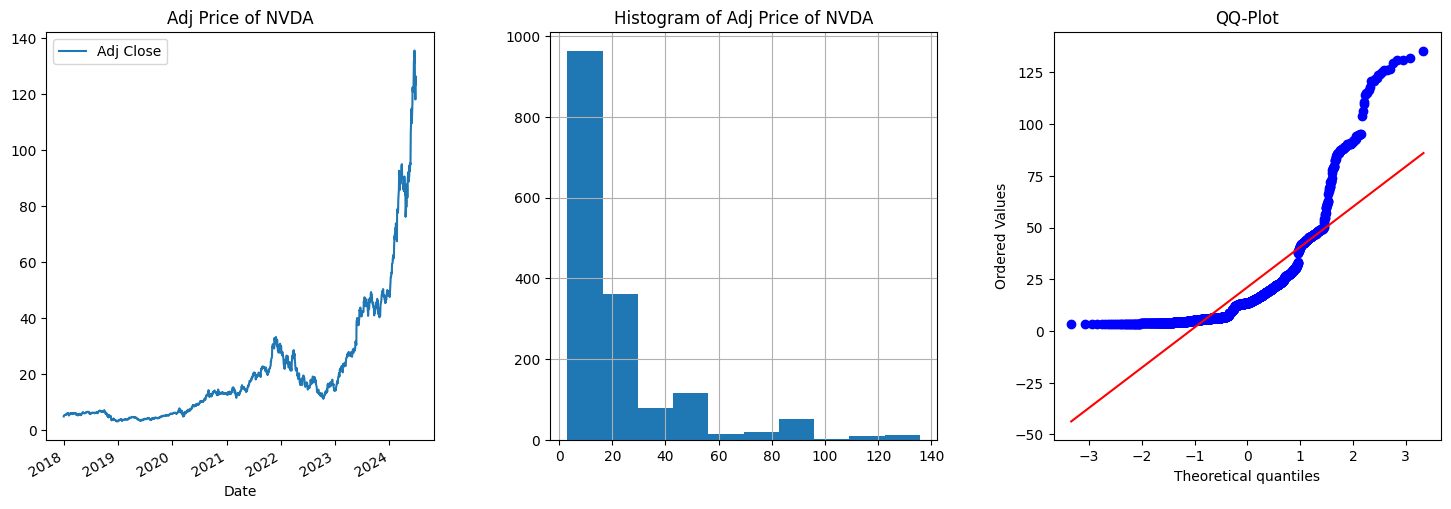

In [9]:
Analizer.show_distribution()

Showing ACF and PACF of NVDA


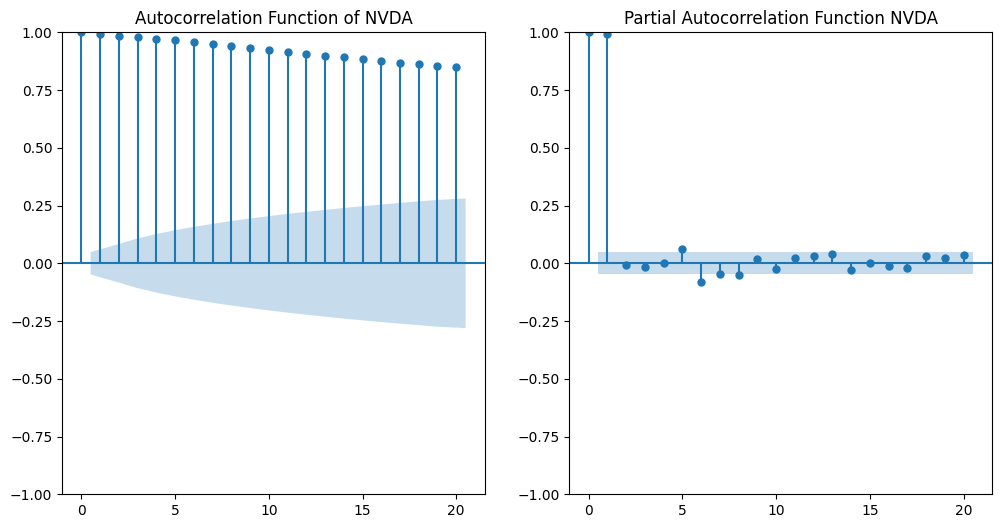

In [10]:
Analizer.show_acf_pacf()

In [11]:
Analizer.apply_adf_test()

###################################################################
Applying ADF Test to NVDA
ADF Statistic: 3.5115007802133715
n_lags: 1.0
p-value: 1.0
Critial Values:
   1%, -3.4344181718827462
Critial Values:
   5%, -2.8633368604103104
Critial Values:
   10%, -2.567726611627638
We Fail to reject null hypothesis of non stationarity


###################################################################
Applying STL Decomposition to NVDA


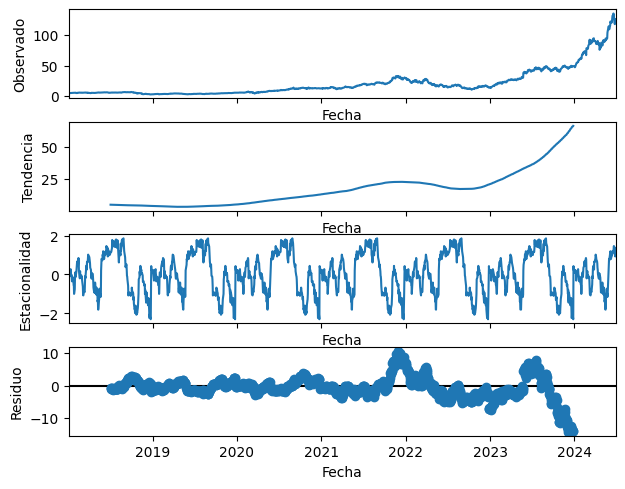

In [12]:
Analizer.apply_STL_decompose()

In [13]:
Analizer.show_basic_statistics(difference=True)


############################################
Showing descriptive statistics!:
              Open         High          Low        Close    Adj Close  \
count  1632.000000  1632.000000  1632.000000  1632.000000  1632.000000   
mean     21.168251    21.558096    20.758406    21.181967    21.153856   
std      23.006150    23.423105    22.532456    23.012159    23.020466   
min       3.162250     3.249500     3.111500     3.177000     3.151916   
25%       6.117625     6.212062     6.021875     6.130313     6.077234   
50%      13.628625    13.839875    13.361750    13.598875    13.566543   
75%      24.362249    25.008750    23.807500    24.418000    24.383590   
max     139.800003   140.759995   130.690002   135.580002   135.580002   

             Volume   Close_Diff  
count  1.632000e+03  1632.000000  
mean   4.775204e+08     0.072677  
std    2.106495e+08     0.998051  
min    9.788400e+07    -8.470299  
25%    3.417230e+08    -0.177463  
50%    4.406720e+08     0.024333  
75%    5.8

###################################################################
Showing distribution of First Difference of NVDA


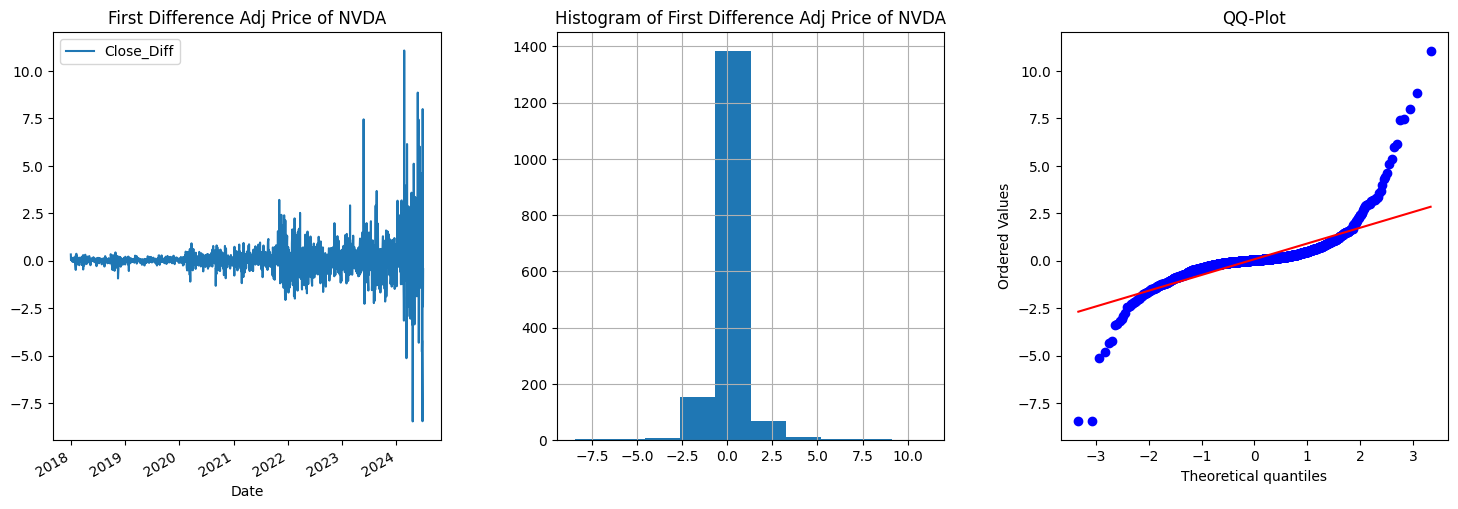

In [14]:
Analizer.show_distribution(difference=True)

###################################################################
Showing ACF and PACF of First Difference for NVDA


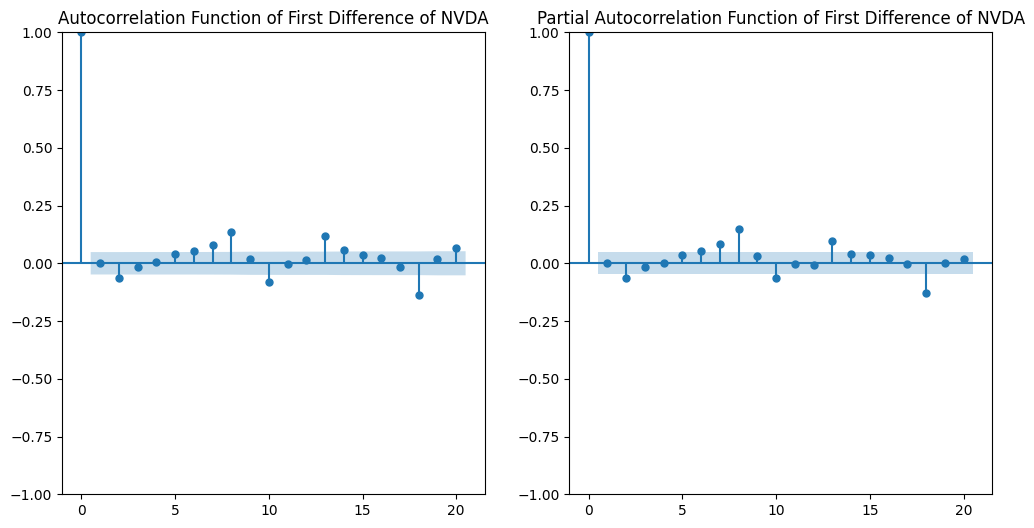

In [15]:
Analizer.show_acf_pacf(difference=True)

In [16]:
Analizer.apply_adf_test(difference=True)

###################################################################
Applying ADF Test to First Difference of NVDA
ADF Statistic: -7.299254133809265
n_lags: 1.352146509829838e-10
p-value: 1.352146509829838e-10
Critial Values:
   1%, -3.4344181718827462
Critial Values:
   5%, -2.8633368604103104
Critial Values:
   10%, -2.567726611627638
We Reject null hypothesis of non stationarity


###################################################################
Applying STL Decomposition to NVDA


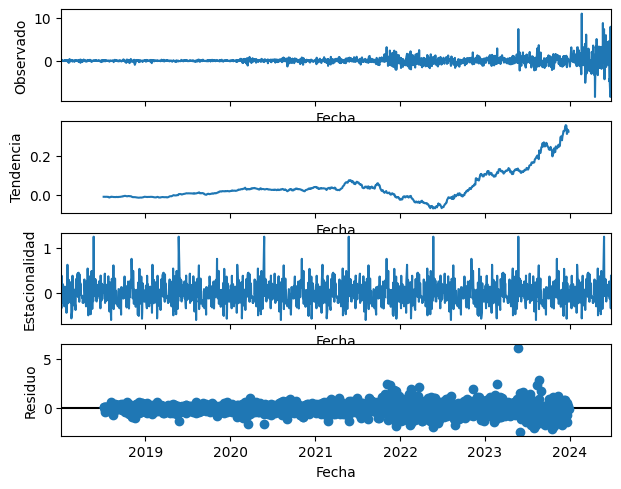

In [17]:
# Descomposición de la serie temporal diferenciada
Analizer.apply_STL_decompose(difference=True)

# Proceso de modelación




## Método naive

In [18]:
class naive_model:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_test_date, end_test_date):
        print("Construyendo modelo naive")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_test_date
        self.end_date = end_test_date

        self.test = objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]

        self.train = self.objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]
        self.data_adjclose = self.train[self.variable_objetivo]
        self.results_df = None

        # Calculo del promedio
        self.valor_naive = self.data_adjclose.iloc[-1]
        print(f'El modelo naive predice a un valor de {self.valor_naive}')

    def forecast(self):
        predictions = [self.valor_naive] * len(self.test)
        return(predictions)

    def get_metrics(self):
        print("###################################################################")
        print("Obteniendo metricas")
        predictions = self.forecast()
        rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
        mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
        mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)
        self.results_df =  pd.DataFrame({'RMSE':[rmse],
                                    'MAPE':[mape],
                                    'MAE':[mae]})
        return(self.results_df)


In [19]:
naive_instancia = naive_model(variable_objetivo="Adj Close", objeto_serietemporal=Analizer, start_test_date="2024-01-01", end_test_date="2024-06-30")

naive_instancia.get_metrics()

Construyendo modelo naive
El modelo naive predice a un valor de 49.51560974121094
###################################################################
Obteniendo metricas


,RMSE,MAPE,MAE
0,43.166537,0.395726,37.58483


## Método Naive Estacional

In [20]:
# Implementar el método de forecast estacional naive
class naive_estacional_model:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_test_date, end_test_date):
        print("Construyendo modelo naive estacional")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_test_date
        self.end_date = end_test_date
        self.train = objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]
        self.start_date_test = start_test_date
        self.end_date = end_test_date
        self.test = objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]
        self.data_adjclose = self.train[self.variable_objetivo]
        self.results_df = None

    def get_metrics(self):
        print("###################################################################")
        print("Obteniendo metricas")
        predictions = self.forecast()
        rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
        mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
        mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)
        self.results_df =  pd.DataFrame({'RMSE':[rmse],
                                  'MAPE':[mape],
                                  'MAE':[mae]})
        return(self.results_df)

    def forecast(self, season_length=252):
        steps = len(self.test)
        forecast = []
        for i in range(steps):
          forecast.append(self.data_adjclose.iloc[-season_length + (i % season_length)])
        return forecast

In [21]:
modelo_snaive_instancia = naive_estacional_model(variable_objetivo="Adj Close", objeto_serietemporal=Analizer, start_test_date="2024-01-01", end_test_date="2024-06-30")

modelo_snaive_instancia.get_metrics()

Construyendo modelo naive estacional
###################################################################
Obteniendo metricas


,RMSE,MAPE,MAE
0,61.672938,0.691933,60.041081


## Método del promedio

In [22]:
class average_model:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_test_date, end_test_date):
        print("Construyendo modelo de promedio")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_test_date
        self.end_date = end_test_date
        self.test = objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]

        self.train = self.objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]

        self.data_adjclose = self.train[self.variable_objetivo]

        self.results_df = None

        # Calculo del promedio
        self.promedio = self.data_adjclose.mean()
        print(f'El modelo del promedio predice a un valor de {self.promedio}')

    def get_metrics(self):
        print("###################################################################")
        print("Obteniendo metricas")
        predictions = self.forecast()
        rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
        mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
        mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)
        self.results_df =  pd.DataFrame({'RMSE':[rmse],
                                    'MAPE':[mape],
                                    'MAE':[mae]})
        return(self.results_df)


    def forecast(self):
        predictions = [self.promedio] * len(self.test)
        return(predictions)

In [23]:
Instancia_promedio = average_model(variable_objetivo="Adj Close", objeto_serietemporal=Analizer, start_test_date="2024-01-01", end_test_date="2024-06-30")

Instancia_promedio.get_metrics()

Construyendo modelo de promedio
El modelo del promedio predice a un valor de 15.738162235334634
###################################################################
Obteniendo metricas


,RMSE,MAPE,MAE
0,74.414911,0.807374,71.277514


## Regresión lineal

$$Y_{t}=\beta_{0}+\beta_{1}t+\epsilon_{t}$$

In [24]:
class regression_model:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_test_date, end_test_date):
        print("Construyendo modelo de regresión basado en tendencia temporal")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_test_date
        self.end_date = end_test_date
        self.test = objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]

        self.train = self.objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]

        self.data_adjclose = self.train[self.variable_objetivo]

        # Detrend
        self.timeTrend = np.linspace(1, len(self.data_adjclose), len(self.data_adjclose))
        self.timeTrend = sm.add_constant(self.timeTrend)

        self.timeTrend_test = np.linspace(len(self.data_adjclose), len(self.test), len(self.test))
        self.timeTrend_test = sm.add_constant(self.timeTrend_test)

        # Fit OLS
        model = sm.OLS(self.data_adjclose, self.timeTrend)
        self.fit_g = model.fit()
        print(self.fit_g.summary())

    def plot_residuals(self):
        res = self.fit_g.resid
        res.plot(linewidth=1.3, xlabel="Year", ylabel="Residuals")
        plt.show()

    def forecast(self):
        predictions = self.fit_g.predict(self.timeTrend_test)
        return(predictions)

    def get_metrics(self):
        print("###################################################################")
        print("Obteniendo metricas")
        predictions = self.forecast()
        rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
        mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
        mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)
        results_df =  pd.DataFrame({'RMSE':[rmse],
                                    'MAPE':[mape],
                                    'MAE':[mae]})
        return(results_df)



In [25]:
regression_instancia = regression_model(variable_objetivo="Adj Close", objeto_serietemporal=Analizer, start_test_date="2024-01-01", end_test_date="2024-06-30")

Construyendo modelo de regresión basado en tendencia temporal
                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     3691.
Date:                Fri, 05 Jul 2024   Prob (F-statistic):               0.00
Time:                        21:24:23   Log-Likelihood:                -4981.7
No. Observations:                1508   AIC:                             9967.
Df Residuals:                    1506   BIC:                             9978.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

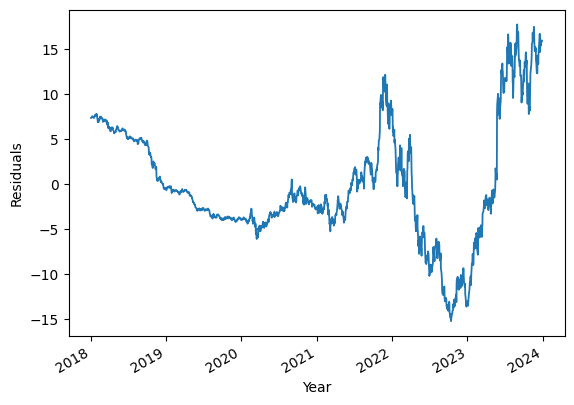

In [26]:
regression_instancia.plot_residuals()

In [27]:
regression_instancia.get_metrics()

###################################################################
Obteniendo metricas


,RMSE,MAPE,MAE
0,76.160228,0.76189,69.821489


## ARIMA (Autoregressive Integrated Moving Average)

In [28]:
class arima_optimizer:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_date_test, end_date_test):
        print("###################################################################")
        print("Creando estructuras basicas para el objeto ARIMA")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_date_test
        self.end_date_test = end_date_test

        self.results_df = None
        self.final_arima_model_results = None
        self.best_params = None

        self.test = self.objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]

        self.train = self.objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]
        print("###################################################################")
        print('Especificaciones de el set de entrenamiento')
        print(self.train.info())

        print("###################################################################")
        print('Especificaciones de el set de prueba')
        print(self.test.info())

    def optimize(self):
        print("###################################################################")
        print("Optimizando modelo ARIMA")

        # Define the range of p, d, and q values
        p_values = range(0, 3)  # Replace with your desired range
        d_values = range(0, 3)  # Replace with your desired range
        q_values = range(0, 3)  # Replace with your desired range

        # Create a list with all possible combinations of p, d, and q
        pdq_combinations = list(itertools.product(p_values, d_values, q_values))
        print(f"Probando este número de combinaciones de hiperparámetros: {len(pdq_combinations)}")

        # Initialize variables to store best parameters and minimum AIC
        best_params = None
        best_aic = float("inf")
        bests_rmse = float("inf")

        p_list = []
        d_list = []
        q_list = []
        aic_list = []
        rmse_list = []
        mape_list = []
        mae_list  = []

        # Iterate through all combinations
        for pdq in pdq_combinations:
          print(f'Construyendo y evaluando ARIMA: {pdq}')
          #try:
          # Fit ARIMA model
          model = sm.tsa.ARIMA(self.train[self.variable_objetivo], order=pdq)
          results = model.fit()

          # Check AIC (Akaike Information Criterion)
          aic_list.append(results.aic)

          # Make predictions on the testing set
          predictions = results.predict(start=len(self.train), end=len(self.train)+len(self.test)-1)

          # Calculate RMSE and MAPE
          rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
          mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
          mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)

          #Saving results in lists
          rmse_list.append(rmse)
          mape_list.append(mape)
          mae_list.append(mae)
          p_list.append(pdq[0])
          d_list.append(pdq[1])
          q_list.append(pdq[2])

        # Initialize a DataFrame to store results
        self.results_df =  pd.DataFrame({'p': p_list,
                                    'd': d_list,
                                    'q': q_list,
                                    'AIC': aic_list,
                                    'RMSE':rmse_list,
                                    'MAPE':mape_list,
                                    'MAE':mae_list})

          #except Exception as e:
            #print('Hubo un error!')
            #continue

        # Sort results by AIC in ascending order
        self.results_df = self.results_df.sort_values(by='RMSE')

        return(self.results_df)

    def get_optimal_ARIMA(self):
      # Fit the final model with the best parameters
      self.best_params = (self.results_df.iloc[0]['p'], self.results_df.iloc[0]['d'], self.results_df.iloc[0]['q'])
      self.final_arima_model = sm.tsa.ARIMA(self.train[self.variable_objetivo], order= self.best_params)
      self.final_arima_model_results = self.final_arima_model.fit()

      # Print the summary of the final model
      print(self.final_arima_model_results.summary())

      return(self.final_arima_model)

    def forecast(self):
      predictions = self.final_arima_model_results.predict(start=len(self.train), end=len(self.train)+len(self.test)-1)
      return(predictions)

    def show_residuals(self):
      # Standardized Residuals for Optimal ARIMA Model
      fit_res = self.final_arima_model_results.resid
      fit_res_sta = fit_res / np.std(fit_res, ddof=1)
      plt.plot(fit_res_sta)
      plt.ylabel("Standardized Residuals")
      plt.show()

In [29]:
start_date_test = pd.to_datetime('2024-01-02')
end_date_test = pd.to_datetime('2024-06-28')

arima_instancia = arima_optimizer("Adj Close", Analizer, start_date_test, end_date_test)
arima_instancia.optimize()

###################################################################
Creando estructuras basicas para el objeto ARIMA
###################################################################
Especificaciones de el set de entrenamiento
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2018-01-03 to 2023-12-29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1508 non-null   float64
 1   High        1508 non-null   float64
 2   Low         1508 non-null   float64
 3   Close       1508 non-null   float64
 4   Adj Close   1508 non-null   float64
 5   Volume      1508 non-null   int64  
 6   Close_Diff  1508 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 94.2 KB
None
###################################################################
Especificaciones de el set de prueba
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2024-01-02 to 2024-06-28
Data columns (total 7 colu

,p,d,q,AIC,RMSE,MAPE,MAE
25,2,2,1,2741.178618,38.372946,0.351018,33.347998
26,2,2,2,2741.378260,38.441477,0.351701,33.411265
8,0,2,2,2739.453284,38.508178,0.352284,33.467903
16,1,2,1,2739.462791,38.514680,0.352345,33.473670
7,0,2,1,2737.789847,38.655048,0.353660,33.598187
17,1,2,2,2740.680551,38.805483,0.355104,33.733712
24,2,2,0,3195.364059,39.089389,0.357661,33.979381
15,1,2,0,3360.664463,40.683816,0.372569,35.391313
23,2,1,2,2731.355072,43.135391,0.395322,37.550697
3,0,1,0,2733.708868,43.166537,0.395726,37.584830


In [30]:
#arima_instancia.show_residuals()

## SARIMA (Seasonal Autoregressive Integrated Moving Average)

In [31]:
class sarima_optimizer:
    def __init__(self, variable_objetivo, objeto_serietemporal, start_date_test, end_date_test):
        print("###################################################################")
        print("Creando estructuras basicas para el objeto SARIMA")
        self.variable_objetivo = variable_objetivo
        self.objeto_serietemporal = objeto_serietemporal
        self.start_date_test = start_date_test
        self.end_date_test = end_date_test

        self.results_df = None
        self.final_sarima_model_results = None
        self.best_params = None

        self.test = self.objeto_serietemporal.data
        self.test = self.test[self.test.index >= self.start_date_test]

        self.train = self.objeto_serietemporal.data
        self.train = self.train[self.train.index < self.start_date_test]

        print("###################################################################")
        print('Especificaciones de el set de entrenamiento')
        print(self.train.info())

        print("###################################################################")
        print('Especificaciones de el set de prueba')
        print(self.test.info())

    def optimize(self):
        print("###################################################################")
        print("Optimizando modelo SARIMA")

        # Define the range of p, d, q, P, D, Q, and seasonal period (m) values
        p_values = range(0, 3)  # Replace with your desired range
        d_values = range(0, 2)  # Replace with your desired range
        q_values = range(0, 3)  # Replace with your desired range
        P_values = range(0, 3)  # Replace with your desired range
        D_values = range(0, 2)  # Replace with your desired range
        Q_values = range(0, 3)  # Replace with your desired range
        m_values = [5]  # Replace with your seasonal period

        # Create a list with all possible combinations of SARIMA parameters
        sarima_combinations = list(itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values))

        # Initialize a DataFrame to store results
        # Initialize variables to store best parameters and minimum AIC
        best_params = None
        best_aic = float("inf")
        bests_rmse = float("inf")

        p_list = []
        d_list = []
        q_list = []
        P_list = []
        D_list = []
        Q_list = []
        m_list = []
        aic_list = []
        rmse_list = []
        mape_list = []
        mae_list  = []

        # Iterate through all combinations
        for sarima_params in sarima_combinations:
            try:
              print(f'Construyendo y evaluando SARIMA: {sarima_params}')
              # Fit SARIMA model
              model = sm.tsa.SARIMAX(self.train[self.variable_objetivo], order=(sarima_params[0], sarima_params[1], sarima_params[2]),
                                seasonal_order=(sarima_params[3], sarima_params[4], sarima_params[5], sarima_params[6]))
              results = model.fit()

              # Check AIC (Akaike Information Criterion)
              aic_list.append(results.aic)

              # Make predictions on the testing set
              predictions = results.predict(start=len(self.train), end=len(self.train)+len(self.test)-1)

              # Calculate RMSE and MAPE
              rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
              mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
              mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)

              #Saving results in lists
              rmse_list.append(rmse)
              mape_list.append(mape)
              mae_list.append(mae)
              p_list.append(sarima_params[0])
              d_list.append(sarima_params[1])
              q_list.append(sarima_params[2])
              P_list.append(sarima_params[3])
              D_list.append(sarima_params[4])
              Q_list.append(sarima_params[5])
              m_list.append(sarima_params[6])

            except Exception as e:
              print('Hubo un error!')
              continue

        # Initialize a DataFrame to store results
        self.results_df =  pd.DataFrame({'p': p_list,
                                    'd': d_list,
                                    'q': q_list,
                                    'P': P_list,
                                    'D': D_list,
                                    'Q': Q_list,
                                    'm': m_list,
                                    'AIC': aic_list,
                                    'RMSE':rmse_list,
                                    'MAPE':mape_list,
                                    'MAE':mae_list})



        # Sort results by AIC in ascending order
        self.results_df = self.results_df.sort_values(by='RMSE')

        return(self.results_df)

    def get_optimal_SARIMA(self):

      # Select the best parameters
      self.best_params_sarima = self.results_df.iloc[0][['p', 'd', 'q', 'P', 'D', 'Q', 'm']]

      # Print the best parameters
      print(f"\nBest SARIMA parameters: {self.best_params_sarima}")

      # Fit the final SARIMA model with the best parameters
      final_model_sarima = sm.tsa.SARIMAX(self.train[self.variable_objetivo],
                                          order=(self.best_params_sarima['p'], self.best_params_sarima['d'], self.best_params_sarima['q']),
                                     seasonal_order=(self.best_params_sarima['P'], self.best_params_sarima['D'], self.best_params_sarima['Q'],
                                                     self.best_params_sarima['m']))
      self.final_results_sarima = final_model_sarima.fit()

      # Print the summary of the final SARIMA model
      print(self.final_results_sarima.summary())

      return(self.final_results_sarima)

    def forecast(self):
      predictions = self.final_results_sarima.predict(start=len(self.train), end=len(self.train)+len(self.test)-1)
      return(predictions)

In [32]:
sarima_instancia = sarima_optimizer("Adj Close", Analizer, start_date_test, end_date_test)
sarima_instancia.optimize()

###################################################################
Creando estructuras basicas para el objeto SARIMA
###################################################################
Especificaciones de el set de entrenamiento
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1508 entries, 2018-01-03 to 2023-12-29
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        1508 non-null   float64
 1   High        1508 non-null   float64
 2   Low         1508 non-null   float64
 3   Close       1508 non-null   float64
 4   Adj Close   1508 non-null   float64
 5   Volume      1508 non-null   int64  
 6   Close_Diff  1508 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 94.2 KB
None
###################################################################
Especificaciones de el set de prueba
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2024-01-02 to 2024-06-28
Data columns (total 7 col

,p,d,q,P,D,Q,m,AIC,RMSE,MAPE,MAE
213,1,1,2,2,1,0,5,3192.640586,32.154870,0.291855,27.767773
303,2,1,1,2,1,0,5,3192.645492,32.155092,0.291858,27.767976
321,2,1,2,2,1,0,5,3194.967708,32.195505,0.292246,27.804572
285,2,1,0,2,1,0,5,3191.053042,32.195957,0.292251,27.804994
105,0,1,2,2,1,0,5,3191.063601,32.200071,0.292291,27.808716
...,...,...,...,...,...,...,...,...,...,...,...
19,0,0,1,0,0,1,5,9701.751655,89.168973,0.978676,85.968808
1,0,0,0,0,0,1,5,11369.681012,89.225586,0.981456,86.110962
36,0,0,2,0,0,0,5,9607.372321,89.474746,0.992971,86.678090
18,0,0,1,0,0,0,5,11279.070375,89.529852,0.996299,86.837451


In [33]:
sarima_instancia.get_optimal_SARIMA()


Best SARIMA parameters: p    1.0
d    1.0
q    2.0
P    2.0
D    1.0
Q    0.0
m    5.0
Name: 213, dtype: float64
                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                 1508
Model:             SARIMAX(1, 1, 2)x(2, 1, [], 5)   Log Likelihood               -1590.320
Date:                            Fri, 05 Jul 2024   AIC                           3192.641
Time:                                    21:42:25   BIC                           3224.528
Sample:                                         0   HQIC                          3204.519
                                           - 1508                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------


## Modelo STL (Descomposición Seasonal Trend Decomposition using Loess)

In [34]:
from statsmodels.tsa.arima.model import ARIMA

class STL_model:
  def __init__(self, variable_objetivo, objeto_serietemporal, start_date_test, end_date_test):
    print("###################################################################")
    print("Creando estructuras basicas para el objeto STL")
    self.variable_objetivo = variable_objetivo
    self.objeto_serietemporal = objeto_serietemporal
    self.start_date_test = start_date_test
    self.end_date_test = end_date_test
    self.train = self.objeto_serietemporal.data
    self.train = self.train[self.train.index < self.start_date_test]
    self.test = self.objeto_serietemporal.data
    self.test = self.test[self.test.index >= self.start_date_test]
    self.adj_close = self.train[self.variable_objetivo]
    self.stlf = STLForecast(self.adj_close.to_numpy(), ARIMA, model_kwargs=dict(order=(1, 1, 0), trend="t"), period=252)
    self.stlf_res = self.stlf.fit()

    self.results_df = None

  def forecast(self):
    predictions = self.stlf_res.forecast(steps=len(self.test))
    return(predictions)

  def get_metrics(self):
    print("###################################################################")
    print("Obteniendo metricas")
    predictions = self.forecast()
    rmse = np.sqrt(mean_squared_error(self.test[self.variable_objetivo], predictions))
    mape = mean_absolute_percentage_error(self.test[self.variable_objetivo], predictions)
    mae = mean_absolute_error(self.test[self.variable_objetivo], predictions)
    self.results_df =  pd.DataFrame({'RMSE':[rmse],
                                    'MAPE':[mape],
                                    'MAE':[mae]})
    return(self.results_df)


In [35]:
stl_instancia = STL_model("Adj Close", Analizer, start_date_test, end_date_test)

stl_instancia.get_metrics()

###################################################################
Creando estructuras basicas para el objeto STL
###################################################################
Obteniendo metricas


,RMSE,MAPE,MAE
0,37.67869,0.34622,32.856751


In [36]:
from scipy.signal import periodogram

def get_periodogram(data, variable_target):
  # Supongamos que 'data' es un DataFrame con la serie temporal
  serie = data[variable_target]  # Ajusta el nombre de la columna según tu dataset

  # Calcular el periodograma
  frecuencias, potencia = periodogram(serie, scaling='density')

  # Graficar el periodograma
  plt.figure(figsize=(10, 6))
  plt.plot(frecuencias, potencia)
  plt.xlabel('Frecuencia')
  plt.ylabel('Densidad de Potencia')
  plt.title('Periodograma')
  plt.show()

  # Identificar la frecuencia estacional más prominente
  frecuencia_estacional = frecuencias[np.argmax(potencia)]
  print(f'Frecuencia estacional detectada: {frecuencia_estacional}')

  # Convertir frecuencia a periodo
  periodo_estacional = int(1 / frecuencia_estacional)
  print(f'Periodo estacional: {periodo_estacional}')

  return(frecuencia_estacional)


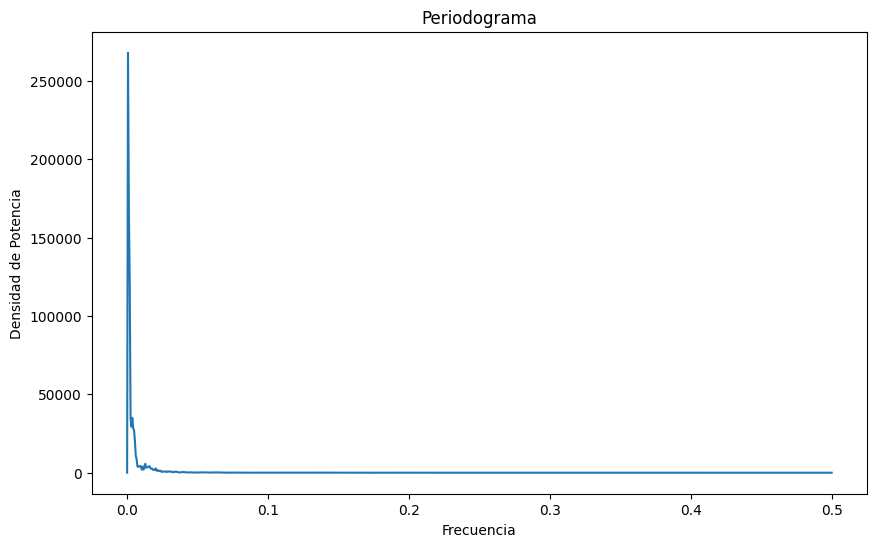

Frecuencia estacional detectada: 0.0006127450980392157
Periodo estacional: 1632


0.0006127450980392157

In [37]:
get_periodogram(data=Analizer.data, variable_target = "Adj Close")
